In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score, log_loss
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import joblib

In [2]:
original_df = pd.read_csv('Data/diabetes_012_health_indicators_BRFSS2015.csv')
# Check missing values
print(original_df.isnull().sum())

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64


In [3]:
print('Distribution for the values of for the target variable\n')
print(original_df["Diabetes_012"].value_counts())

Distribution for the values of for the target variable

Diabetes_012
0.0    213703
2.0     35346
1.0      4631
Name: count, dtype: int64


<Axes: ylabel='count'>

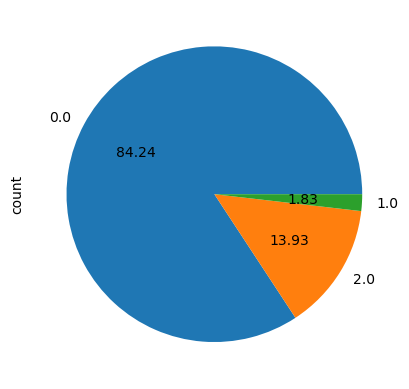

In [4]:
original_df["Diabetes_012"].value_counts().plot.pie(autopct='%.2f')

In [5]:
y = original_df.Diabetes_012
X = original_df.drop('Diabetes_012', axis=1)
X.head(1)

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0


#### Feature Engineering & Scaling
- Turn categorical data into a numerical format that a model can understand.
- Scale numeric features to ensures all features are on the same scale.

In [6]:
# Numerical Predictors
numerical_cols = ['BMI', 'MentHlth', 'PhysHlth', 'Age']
# numerical_cols = list(dict.fromkeys(numerical_cols))  # Remove duplicates just in case

# Categorical Predictors
categorical_cols = [
    'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack',
    'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare',
    'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Education', 'Income'
]

# One-hot encode categorical features and drop the first category of each
# Feature Engineering - Turns categorical data into a numerical format that a model can understand
X_cat = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Extract the numerical features
X_num = X[numerical_cols]

# Concatenate numerical and encoded categorical features
X = pd.concat([X_num, X_cat], axis=1)

# Remove any duplicated columns that may result from concat
X = X.loc[:, ~X.columns.duplicated()]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaler will only fit on training data so, calculates Mean & STD and stores this on the scaler
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols]) # Uses scaler that has only seen the traning data -> standardize 

# Combine transformed training group +  assigned clean, matching row indices
df_train = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)

#### Random Undersampling
- Resample the all classes to equal amounts based on smallest minority.  This way they are not dominated by the majority class.
- randomly removing a bunch of majority class samples.
#### Use after standardizing and removing outliers
-  If you use raw, unencoded categorical columns, it treats these like numbers and may misinterpret them — or worse, raise an error.
-  Feature scaling is also done before undersamling as well.  Using full training set to calculate accurate mean and std to ensures all features are on the same scale.
-  Remove outliers 1st as outliers can skew your feature distributions, especially in the majority class.

In [7]:
# Separate features and target using only the training data
X_train_under = df_train.drop('Diabetes_012', axis=1)
y_train_under = df_train['Diabetes_012']

# from collections import Counter

# Check class distribution before
print("Before undersampling:", Counter(y_train_under))

# Apply undersampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_under, y_train_under)

# Check class distribution after
print("After undersampling:", Counter(y_resampled))

Before undersampling: Counter({0.0: 170908, 2.0: 28349, 1.0: 3687})
After undersampling: Counter({0.0: 3687, 1.0: 3687, 2.0: 3687})


<Axes: ylabel='count'>

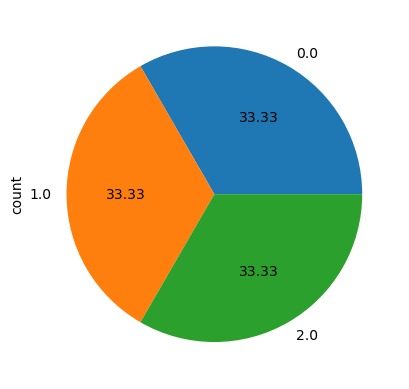

In [8]:
y_resampled.value_counts().plot.pie(autopct='%.2f')

#### SMOTE Random oversampling method
#### Synthetic Minority Over-sampling Technique
- API's for other imbalanced datasets https://imbalanced-learn.org/stable/references/index.html
- Create artificial samples of the minorty class/es
- Uses K nearest neighbors

In [9]:
# Separate features and target
X_train_over = df_train.drop('Diabetes_012', axis=1)
y_train_over = df_train['Diabetes_012']

# Check original class distribution
print("Before SMOTE oversampling:", Counter(y_train_over))

# Apply SMOTE to training set only
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_over, y_train_over)

# Check new class distribution
print("After SMOTE oversampling:", Counter(y_resampled))

Before SMOTE oversampling: Counter({0.0: 170908, 2.0: 28349, 1.0: 3687})
After SMOTE oversampling: Counter({0.0: 170908, 2.0: 170908, 1.0: 170908})


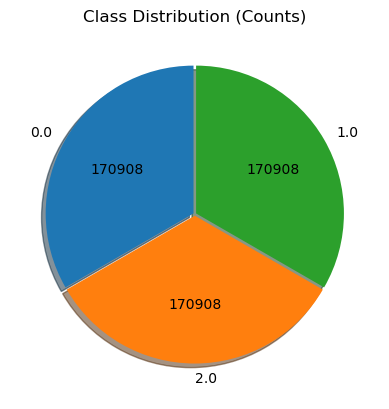

In [10]:
y_resampled.value_counts().plot.pie(
    labels=y_resampled.value_counts().index,
    autopct=lambda p: f'{int(p * sum(y_resampled.value_counts()) / 100)}',
    startangle=90,
    explode=[0.01]*len(y_resampled.value_counts()),
    shadow=True
)
plt.ylabel("")  # Optional: Remove 'y_resampled' label on side
plt.title("Class Distribution (Counts)")
plt.show()

#### TomekLinks
- Useful when there's likely class overlap or poor separation (often the case in real-world health data).
- Instead of aggressively undersampling, it selectively removes the closest conflicting pairs (cleaning the decision boundary).
- Retains more useful majority class information than random undersampling.
- First, use TomekLinks to clean the borderline noise.  Then apply RandomUnderSampler to balance the classes.
- TomekLinks can accidentally remove useful support vectors, so you want to be careful using it with SVM

In [14]:
from imblearn.under_sampling import TomekLinks, RandomUnderSampler

tl = TomekLinks()

# Get X and y values
X_train_TomekLinks = df_train.drop('Diabetes_012', axis=1)
y_train_TomekLinks = df_train['Diabetes_012']

# Check original class distribution
print("Before TomekLinks Under sampling:", Counter(y_train_TomekLinks))

X_clean, y_clean = tl.fit_resample(X_train_TomekLinks, y_train_TomekLinks)

# Check new class distribution
print("After TomekLinks Under sampling:", Counter(y_clean))

# Step 2: Undersample majority class
rus = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
X_under, y_under = rus.fit_resample(X_train_TomekLinks, y_train_TomekLinks)

# Check class distribution after
print("After Under sampling:", Counter(y_under))

Before TomekLinks Under sampling: Counter({0.0: 170908, 2.0: 28349, 1.0: 3687})
After TomekLinks Under sampling: Counter({0.0: 162341, 2.0: 20487, 1.0: 3687})
After undersampling: Counter({0.0: 3687, 1.0: 3687, 2.0: 3687})


#### Edited Nearest Neighbours (ENN)
- ENN removes mislabeled outliers, not borderline points that genuinely reflect the class boundary.
- It’s more selective and data-driven than RandomUnderSampler.
- It avoids over-simplifying your dataset while still reducing noise.

In [15]:
from imblearn.under_sampling import EditedNearestNeighbours

X_train_enn = df_train.drop('Diabetes_012', axis=1)
y_train_enn = df_train['Diabetes_012']

# Check original class distribution
print("Before ENN Under sampling:", Counter(y_train_enn))

enn = EditedNearestNeighbours(n_neighbors=3)
X_enn, y_enn = enn.fit_resample(X_train_enn, y_train_enn)

# Check class distribution after
print("After Under ENN sampling:", Counter(y_enn))

Before ENN Under sampling: Counter({0.0: 170908, 2.0: 28349, 1.0: 3687})
After Under ENN sampling: Counter({0.0: 121330, 1.0: 3687, 2.0: 1471})
